In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')


In [22]:
df_merged = pd.read_csv("data\_2019\_merged\merged_data.csv")
df_merged 

,valid_time,latitude,longitude,max_temperature,mean_temperature,max_precipitation,mean_precipitation,mslp
0,01-01-19,18.80,72.8,299.21042,296.81256,0.000000e+00,0.000000e+00,101726.086
1,01-01-19,19.05,72.8,299.89655,296.60733,0.000000e+00,0.000000e+00,101731.230
2,02-01-19,18.80,72.8,299.55840,297.16934,0.000000e+00,0.000000e+00,101696.210
3,02-01-19,19.05,72.8,300.08356,296.94342,0.000000e+00,0.000000e+00,101702.500
4,03-01-19,18.80,72.8,299.06940,297.01758,0.000000e+00,0.000000e+00,101749.590
...,...,...,...,...,...,...,...,...
725,29-12-19,19.05,72.8,301.35780,298.70673,2.620000e-05,1.730000e-06,101194.120
726,30-12-19,18.80,72.8,299.42170,298.01070,0.000000e+00,0.000000e+00,101193.810
727,30-12-19,19.05,72.8,299.78290,297.80020,1.910000e-07,7.940000e-09,101193.180
728,31-12-19,18.80,72.8,298.12000,296.77167,9.530000e-08,3.970000e-09,101329.120


In [23]:
df_merged["valid_time"] = pd.to_datetime(df_merged["valid_time"], format="%d-%m-%y")
df_merged["month"] = df_merged["valid_time"].dt.month

# Group by month and calculate mean values for visualization
monthly_data = df_merged.groupby("month").mean()

# Set figure size
plt.figure(figsize=(2, 2))

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

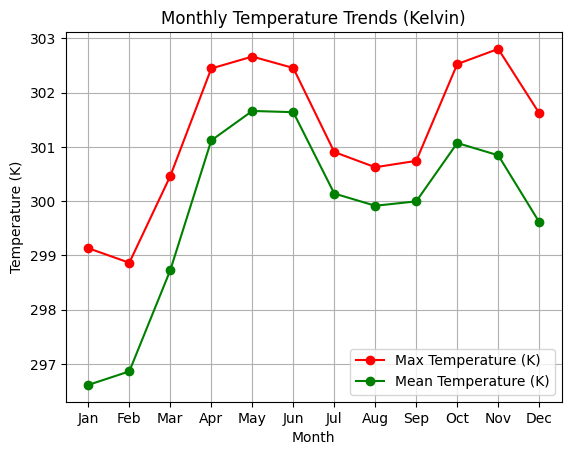

In [14]:
# Plot 1: Temperature Trends
plt.subplot(1, 1, 1)
plt.plot(monthly_data.index, monthly_data["max_temperature"], label="Max Temperature (K)", color="red", marker="o")
plt.plot(monthly_data.index, monthly_data["mean_temperature"], label="Mean Temperature (K)", color="green", marker="o")
plt.xlabel("Month")
plt.ylabel("Temperature (K)")
plt.title("Monthly Temperature Trends (Kelvin)")
plt.xticks(range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(True)
plt.legend()
plt.show()


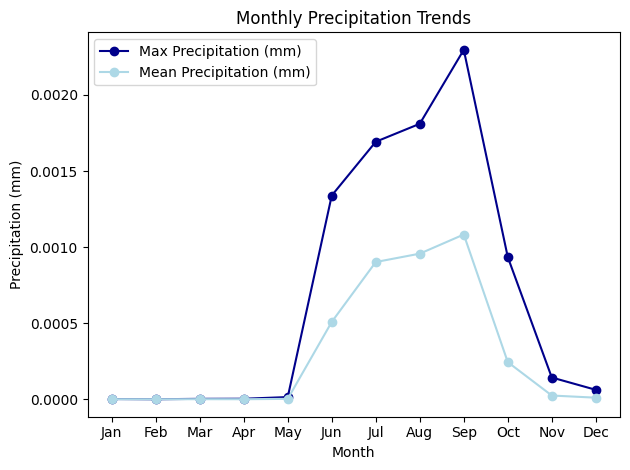

In [15]:
plt.subplot(1, 1, 1)
plt.plot(monthly_data.index, monthly_data["max_precipitation"], label="Max Precipitation (mm)", color="darkblue", marker="o")
plt.plot(monthly_data.index, monthly_data["mean_precipitation"], label="Mean Precipitation (mm)", color="lightblue", marker="o")
plt.xlabel("Month")
plt.ylabel("Precipitation (mm)")
plt.title("Monthly Precipitation Trends")
plt.xticks(range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.tight_layout()
plt.show()

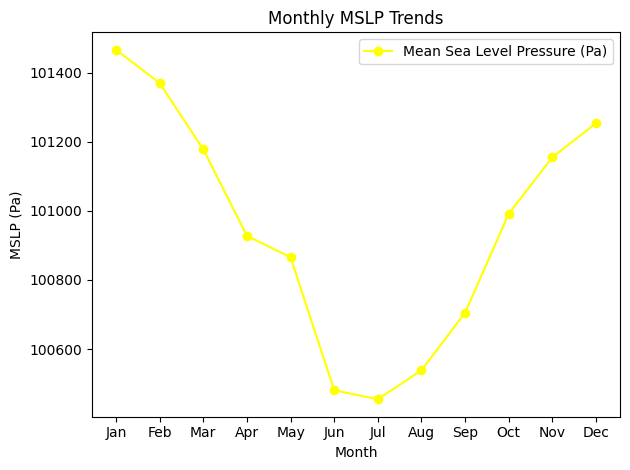

In [16]:
plt.subplot(1, 1, 1)
plt.plot(monthly_data.index, monthly_data["mslp"], label="Mean Sea Level Pressure (Pa)", color="yellow", marker="o")
plt.xlabel("Month")
plt.ylabel("MSLP (Pa)")
plt.title("Monthly MSLP Trends")
plt.xticks(range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Ensure valid_time is in datetime format
df_merged["valid_time"] = pd.to_datetime(df_merged["valid_time"], format="%d-%m-%y", errors="coerce")

# Extract numeric features from date
df_merged["month"] = df_merged["valid_time"].dt.month  # Extract month (1-12)
df_merged["day_of_year"] = df_merged["valid_time"].dt.dayofyear 
df_merged["year"] = df_merged["valid_time"].dt.year         # Extract Year
 # Extract day of year (1-365)

# Drop the original datetime column
df_merged.drop(columns=["valid_time"], inplace=True)

In [18]:

heatwave_threshold = df_merged["max_temperature"].quantile(0.90)
# Create binary class label: 1 if max_temperature exceeds threshold, else 0
df_merged["heatwave_label"] = (df_merged["max_temperature"] > heatwave_threshold).astype(int)


In [19]:
df_merged

,latitude,longitude,max_temperature,mean_temperature,max_precipitation,mean_precipitation,mslp,month,day_of_year,year,heatwave_label
0,18.80,72.8,299.21042,296.81256,0.000000e+00,0.000000e+00,101726.086,1,1,2019,0
1,19.05,72.8,299.89655,296.60733,0.000000e+00,0.000000e+00,101731.230,1,1,2019,0
2,18.80,72.8,299.55840,297.16934,0.000000e+00,0.000000e+00,101696.210,1,2,2019,0
3,19.05,72.8,300.08356,296.94342,0.000000e+00,0.000000e+00,101702.500,1,2,2019,0
4,18.80,72.8,299.06940,297.01758,0.000000e+00,0.000000e+00,101749.590,1,3,2019,0
...,...,...,...,...,...,...,...,...,...,...,...
725,19.05,72.8,301.35780,298.70673,2.620000e-05,1.730000e-06,101194.120,12,363,2019,0
726,18.80,72.8,299.42170,298.01070,0.000000e+00,0.000000e+00,101193.810,12,364,2019,0
727,19.05,72.8,299.78290,297.80020,1.910000e-07,7.940000e-09,101193.180,12,364,2019,0
728,18.80,72.8,298.12000,296.77167,9.530000e-08,3.970000e-09,101329.120,12,365,2019,0


In [24]:
if os.path.exists("data/_2019/_labelled/heat_labelled.csv"):
    print("Files already exist")
else:
    df_merged.to_csv("data/_2019/_labelled/heat_labelled.csv")
    print("File created") 

File created
